### aim: 

### date: 

In [5]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [6]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [7]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

## recreating CLQ

In [10]:
tmeshf = '/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc'
C14d_qtr_c14f = './GCBdata/GEC1_1940_2022_qtrB14b.nc'   ##static
C14d_Cflxf = './GCBdata/GEC1_1940_2022_Cflx.nc' ###static

C14c_qtr_c14f = './GCBdata/GEA1_1940_2022_qtrB14b.nc'
C14c_Cflxf = './GCBdata/GEA1_1940_2022_Cflx.nc'
dc14dzf = './corinneData/dc14dz.nc'

<xarray.DataArray 'time_counter' (time_counter: 996)>
array([cftime.DatetimeNoLeap(1940, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1940, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1940, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2022, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2022, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2022, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
    time_centered  (time_counter) object ...
  * time_counter   (time_counter) object 1940-01-16 12:00:00 ... 2022-12-16 1...
Attributes:
    axis:           T
    standard_name:  time
    long_name:      Time axis
    time_origin:    1950-01-01 00:00:00
    bounds:         time_counter_bounds


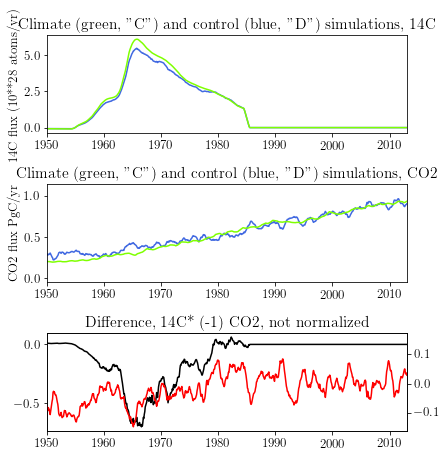

In [11]:
#### ------ A) load data
tmesh = xr.open_dataset(tmeshf)
#climate run
C14d_qtr_c14 = xr.open_dataset(C14d_qtr_c14f)
C14d_Cflx = xr.open_dataset(C14d_Cflxf)
#control run 
C14c_qtr_c14 = xr.open_dataset(C14c_qtr_c14f)
C14c_Cflx = xr.open_dataset(C14c_Cflxf)
#vertical gradient:
dc14dz  = xr.open_dataset(dc14dzf)

#### -------- B) get areas/grid variables
tmask = tmesh.tmask[0,0,:,:] 
area = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
tarea = np.nansum(area)
vol = area * tmesh.e3t_0[0,0]

##### ------ C) "regridding", ie fix the timestamp
times = pd.date_range("1940/01/01","2022/12/01",freq='MS')

qtrnewt_C = C14c_qtr_c14.qtrB14b * tmask.values
cflxnewt_C = C14c_Cflx.Cflx * tmask.values
qtrnewt_D = C14d_qtr_c14.qtrB14b * tmask.values
cflxnewt_D = C14d_Cflx.Cflx * tmask.values

print(qtrnewt_C['time_counter'])

qtrnewt_C['time_counter'] = times
qtrnewt_D['time_counter'] = times
cflxnewt_C['time_counter'] = times
cflxnewt_D['time_counter'] = times


##### ------ D) fluxes
### QQ why volume/10, why not area, wouldn't it be same?
### QQ why these units?/conversion factors?
qtrflx_C = qtrnewt_C * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_C = cflxnewt_C *area.values*3.156e7 
qtrflx_D = qtrnewt_D * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_D = cflxnewt_D *area.values*3.156e7 


fact = 0.8
fig, axs = plt.subplots(3,1, figsize=(8*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


qtrflx_mn_C = qtrflx_C.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
qtrflx_mn_D = qtrflx_D.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_C, color = 'royalblue')
axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_D, color = 'chartreuse')


cflxint_mn_C = cflxint_C.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 
cflxint_mn_D = cflxint_D.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 

axs[1].plot(qtrflx_C.time_counter, cflxint_mn_C, color = 'royalblue')
axs[1].plot(qtrflx_C.time_counter, cflxint_mn_D, color = 'chartreuse')

ax3 = axs[2]
ax3b = ax3.twinx()
ax3.plot(qtrflx_C.time_counter, (qtrflx_mn_D.values-qtrflx_mn_C.values)*-1, color = 'k')
ax3b.plot(qtrflx_C.time_counter, cflxint_mn_D.values-cflxint_mn_C.values, color = 'r')

axs[0].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
axs[1].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
ax3.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
ax3b.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))

axs[0].set_title('Climate (green, "C") and control (blue, "D") simulations, 14C')
axs[1].set_title('Climate (green, "C") and control (blue, "D") simulations, CO2')
axs[2].set_title('Difference, 14C* (-1) CO2, not normalized')

axs[0].set_ylabel('14C flux (10**28 atoms/yr)')
axs[1].set_ylabel('CO2 flux PgC/yr')

plt.tight_layout()
plt.show()

## get out relevant variables from mfdataset for easier handling. 

In [18]:
yrst = 1940; yrend = 1964
extract = False
if extract:
    def make_yearlist(yrst, yrend, dtype, tr, baseDir = '/gpfs/data/greenocean/software/runs/'):
        yrs = np.arange(yrst,yrend+1,1)
        ylist = []
        for i in range(0,len(yrs)):
            ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
            t2 = glob.glob(ty)
            #print(t2)
            ylist.append(t2[0])
        return ylist



    GEA4_diad = xr.open_mfdataset(make_yearlist(yrst,yrend,'diad_T','TOM12_TJ_GEA4'))
    GEC4_diad = xr.open_mfdataset(make_yearlist(yrst,yrend,'diad_T','TOM12_TJ_GEC4'))

    GEA4_diad.qtrB14b.to_netcdf(f'./GCBdata/GEA4_{yrst}_{yrend}_qtrB14b.nc')
    GEC4_diad.qtrB14b.to_netcdf(f'./GCBdata/GEC4_{yrst}_{yrend}_qtrB14b.nc')
    GEA4_diad.Cflx.to_netcdf(f'./GCBdata/GEA4_{yrst}_{yrend}_Cflx.nc')
    GEC4_diad.Cflx.to_netcdf(f'./GCBdata/GEC4_{yrst}_{yrend}_Cflx.nc')

## from recreate CLQ-c14ferret

In [33]:
#### ------ A) load data
tmeshf = '/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc'
tmesh = xr.open_dataset(tmeshf)
C14d_qtr_c14 = xr.open_dataset(f'./GCBdata/GEA4_{yrst}_{yrend}_qtrB14b.nc')   ##static
C14d_Cflx = xr.open_dataset(f'./GCBdata/GEA4_{yrst}_{yrend}_Cflx.nc') ###static

C14c_qtr_c14 = xr.open_dataset(f'./GCBdata/GEC4_{yrst}_{yrend}_qtrB14b.nc')
C14c_Cflx = xr.open_dataset(f'./GCBdata/GEC4_{yrst}_{yrend}_Cflx.nc')

times = pd.date_range(f'{yrst}/01/01',f'{yrend}/12/31',freq='MS')
print(len(times))
#dc14dzf = './corinneData/dc14dz.nc'

300


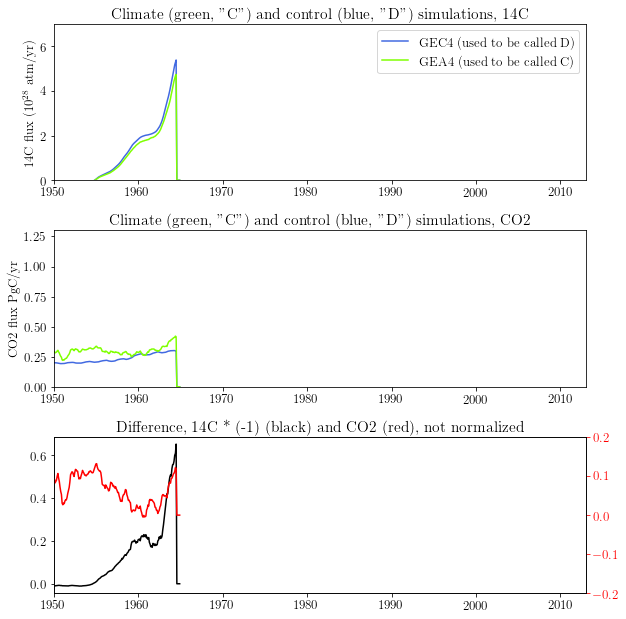

In [52]:

#### -------- B) get areas/grid variables
tmask = tmesh.tmask[0,0,:,:] 
area = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
tarea = np.nansum(area)
vol = area * tmesh.e3t_0[0,0]
tarea2 = np.nansum(vol)/10
# print(tarea)
# print(tarea2)

##### ------ C) "regridding", ie fix the timestamp

qtrnewt_C = C14c_qtr_c14.qtrB14b * tmask.values
cflxnewt_C = C14c_Cflx.Cflx * tmask.values
qtrnewt_D = C14d_qtr_c14.qtrB14b * tmask.values
cflxnewt_D = C14d_Cflx.Cflx * tmask.values

qtrnewt_C['time_counter'] = times
qtrnewt_D['time_counter'] = times
cflxnewt_C['time_counter'] = times
cflxnewt_D['time_counter'] = times


##### ------ D) fluxes
### QQ why volume/10, why not area, wouldn't it be same?
### QQ why these units?/conversion factors?
qtrflx_C = qtrnewt_C * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_C = cflxnewt_C *area.values*3.156e7 
qtrflx_D = qtrnewt_D * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_D = cflxnewt_D *area.values*3.156e7 


fact = 1.1
fig, axs = plt.subplots(3,1, figsize=(8*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


qtrflx_mn_C = qtrflx_C.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
qtrflx_mn_D = qtrflx_D.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_C, color = 'royalblue', label = 'GEC4 (used to be called D)')
axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_D, color = 'chartreuse', label = 'GEA4 (used to be called C)')
axs[0].legend()

cflxint_mn_C = cflxint_C.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 
cflxint_mn_D = cflxint_D.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 

axs[1].plot(qtrflx_C.time_counter, cflxint_mn_C, color = 'royalblue')
axs[1].plot(qtrflx_C.time_counter, cflxint_mn_D, color = 'chartreuse')

ax3 = axs[2]
ax3b = ax3.twinx()
ax3b.tick_params(axis='y', colors='red')
ax3.plot(qtrflx_C.time_counter, (qtrflx_mn_D.values-qtrflx_mn_C.values)*-1, color = 'k')
ax3b.plot(qtrflx_C.time_counter, cflxint_mn_D.values-cflxint_mn_C.values, color = 'r')


axs[0].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
axs[1].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
ax3.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
ax3b.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))

axs[0].set_title('Climate (green, "C") and control (blue, "D") simulations, 14C')
axs[1].set_title('Climate (green, "C") and control (blue, "D") simulations, CO2')
axs[2].set_title('Difference, 14C * (-1) (black) and CO2 (red), not normalized')

axs[0].set_ylabel('14C flux ($10^{28}$ atm/yr)')
axs[1].set_ylabel('CO2 flux PgC/yr')


axs[0].set_ylim([0,7])
axs[1].set_ylim([0,1.3])
# ax3.set_ylim([-0.4,0.4])
ax3b.set_ylim([-0.2,0.2])

plt.tight_layout()
plt.show()

<xarray.DataArray 'e3t_0' (y: 149, x: 182)>
array([[10., 10., 10., ..., 10., 10., 10.],
       [10., 10., 10., ..., 10., 10., 10.],
       [10., 10., 10., ..., 10., 10., 10.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Dimensions without coordinates: y, x